# Wave table with square

### The first task of setting up a square wave in a wave table is in constructing an un-distorted and un-aliased sample of a square wave 

#### I'll start by anylising an infinatly harmonic square wave in the freq domain and extract some frequency and amplitude data

In [30]:
import numpy as np
import cmath
%matplotlib inline
import matplotlib.pyplot as plt

In [31]:
class waveGen:

    def __init__(self, freq, BufferSize, waveType, vol):

        self.sampleRate = 48000
        self.bufferSize = BufferSize
        self.buffer = np.empty(BufferSize, dtype=np.complex)
        self.frequency = freq
        self.omega = 0
        self.updateOmega()
        self.last = complex(1,0)
        self.type = waveType
        self.volume = vol

    def sineGen(self):

        for i in range(0, self.bufferSize):
            self.buffer[i] = self.last
            self.last=self.last*self.omega

        return self.volume * np.imag(self.buffer).astype(np.float32)

    def squareGen(self):
        
        for i in range(0, self.bufferSize):
            self.buffer[i] = np.sign(self.last)
            self.last=self.last*self.omega

        return np.real(self.volume * self.buffer).astype(np.float32)

    def updateOmega(self):
        self.omega = cmath.exp(1j*(2*cmath.pi * self.frequency / self.sampleRate))

    def updateFreq(self, val):
        self.frequency = val
        self.updateOmega()
        
    def updateVol(self, val):
        self.volume = val

    def nextFrame(self):
        if self.type == "sine":
            return self.sineGen()
        elif self.type == "square":
            return self.squareGen()

/usr/lib64/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib64/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


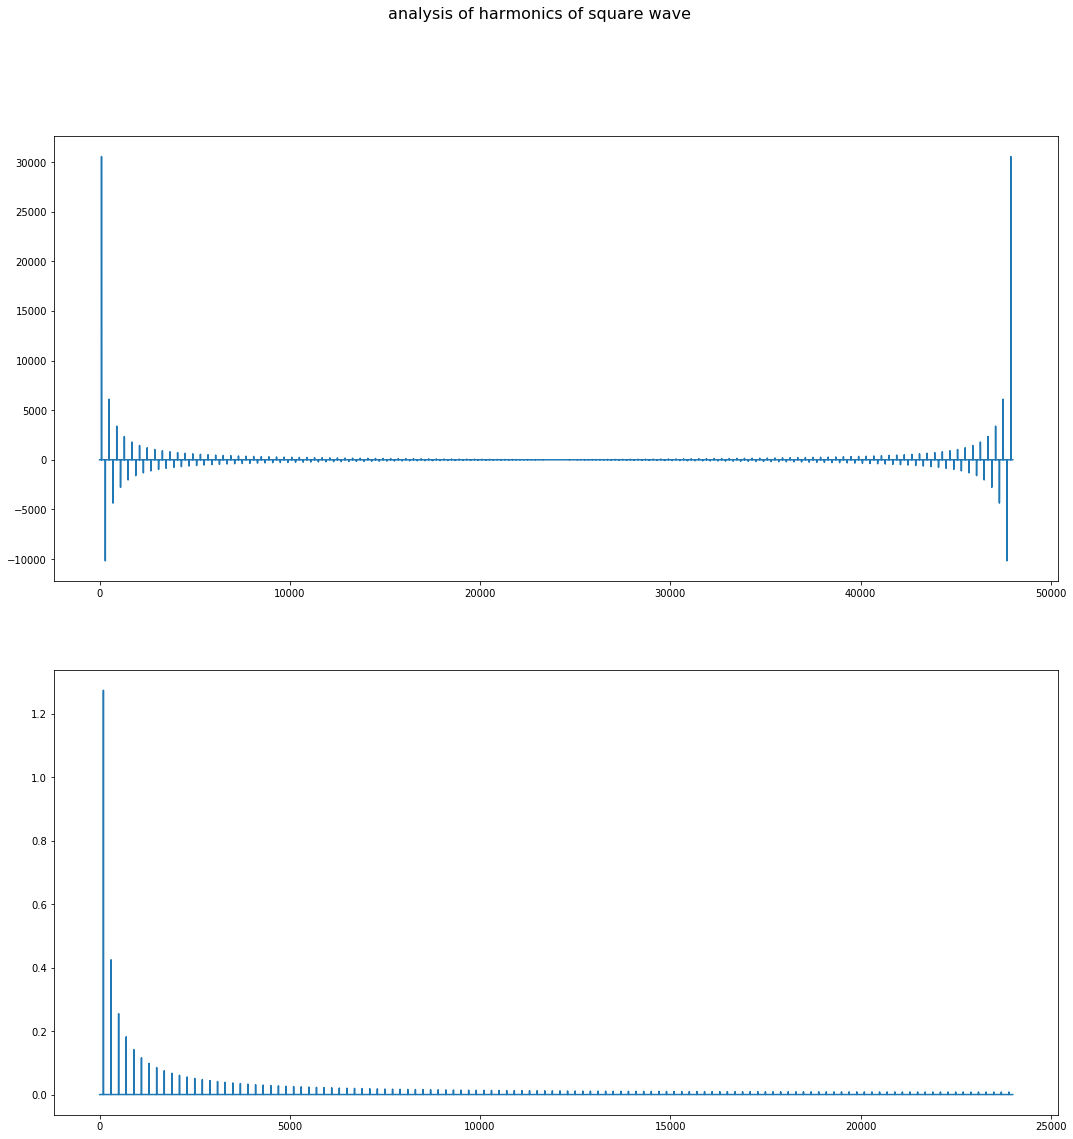

In [32]:
fig = plt.figure(figsize=(18, 18))
fig.suptitle('analysis of harmonics of square wave', fontsize=16)

#a wave for one second at 1 HZ
freq = 100
length = 48000
waver = waveGen(freq, length, 'square', 1)
square = waver.nextFrame()
square_fd = np.fft.fft(square)

fig.add_subplot(2, 1, 1).plot(square_fd)

#linespaceing
T = 1.0 / 48000.0

#x angle of plot
xf = np.linspace(0.0, 1.0/(2.0*T), length//2)

#ploting the graph
fig.add_subplot(2, 1, 2).plot(xf, 2.0/length * np.abs(square_fd[:length//2]))
fig.show()



there are a lot of tiny harmonics shown here,

I'll write a function to parse data

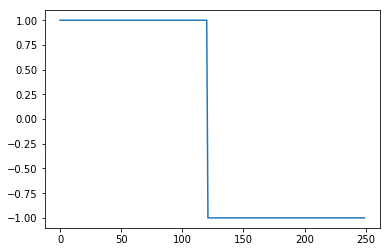

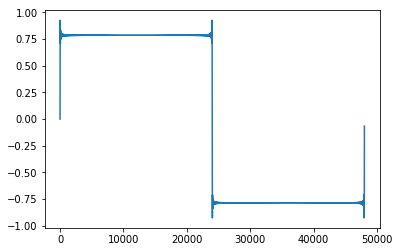

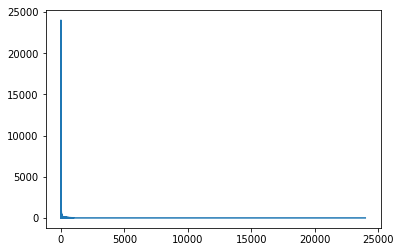

In [37]:
fund = 1
freq = fund
i = 1

wavegen = waveGen(freq, length, 'sine', 1)
wave = np.zeros(length)

while freq < length//2 and 1/i > 0.001:
    
    wavegen.updateFreq(freq)
    wavegen.updateVol(1/i)
    wave += wavegen.nextFrame()
    i += 2
    freq = fund*i


plt.plot(square[:250])
plt.show()

plt.plot(wave)
plt.show()


plt.plot(abs(np.fft.fft(wave)[:length//2]))
plt.show()


## allthough this seems like a good way to additivly build a wave, the fft seems messed up

this was in part mitigated by plotting the imaginary part here

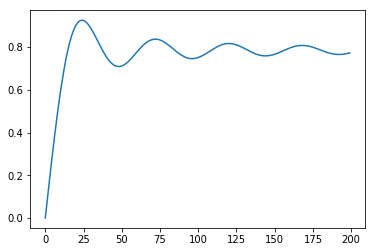

In [34]:
plt.plot(wave[:200])
plt.show()

## loading this into a wave table

In [35]:
class table_Reader:
    def __init__(self, Table, Pitch = 440, FrameSize = 0):
        self.table = Table
        self.tableLen = len(self.table) 
        self.pitch = Pitch
        self.table_index = 0
        self.frameSize = FrameSize
        return
    
    def nextFrame(self, size):
        self.frameSize = size
        return self.take_frame()
        
    def update_pitch(self, val):
        self.pitch = val
        return
    
    def take_frame(self):
        
        output = np.empty(self.frameSize)
        
        for i in range(self.frameSize):
            self.table_index += self.pitch  
            
            if self.table_index >= len(self.table):
                self.table_index -= self.tableLen
            
            output[i] = self.table[self.table_index]
         
        return output


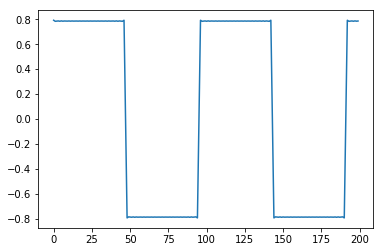

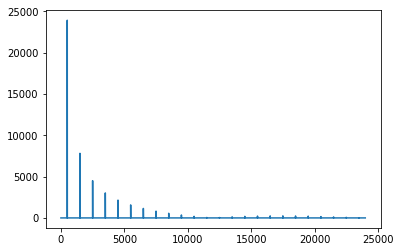

In [36]:
frameSize = length
freq = 500
reader = table_Reader(wave, freq)
output_wave = reader.nextFrame(frameSize)

plt.plot(output_wave[:200])
plt.show()

plt.plot(abs(np.imag(np.fft.fft(output_wave)[:length//2])))
plt.show()


# what is band limiting?

### there may be a way of doing this by rounding to the nearest value of some sort
### this is going to be compliicated - maybe involving a factor of pi
### this would act simillary to limiting the aplitude of any harmonic added in additive sythisis

if this could be inacted in the reader it would be incredable efficient